In [42]:
import sys
sys.path.append('../../..')
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import resnet18
from torch.nn import Conv2d
from core.architecture.experiment.nn_experimenter import ClassificationExperimenter
from core.operation.optimization.structure_optimization import SVDOptimization, SFPOptimization
from core.operation.decomposition.decomposed_conv import DecomposedConv2d
from core.operation.optimization.sfp_tools import _check_nonzero_filters

In [44]:
def check_zero(conv: DecomposedConv2d):
    nonzero = _check_nonzero_filters(conv.weight)
    print(conv.weight.data.shape[0], nonzero.shape[0])

def save_numpy(model: torch.nn.Module, name:str):
    for mname, module in model.named_modules():
        if isinstance(module, Conv2d):
            np.save(f'{name}_{mname}', module.weight.data.cpu().numpy())

def compose_conv(conv: DecomposedConv2d):
    conv.compose()

def show_heatmap(conv: DecomposedConv2d):
    n, c, w, h = conv.weight.size()
    decomposing_modes_dict = {
        'channel': (n, c * w * h),
        'spatial': (n * w, c * h),
    }
    sns.heatmap(conv.weight.data.cpu().view(decomposing_modes_dict['channel']).numpy(), vmin=-0.1, vmax=0.1, center= 0)

In [3]:
svd = SVDOptimization(energy_thresholds=[0.99])
exp = ClassificationExperimenter(model=resnet18(num_classes=21))
svd.load_model(exp=exp, state_dict_path='fine-tuning_e_0.99.sd.pt')
exp.apply_func(compose_conv, condition=lambda x: isinstance(x, DecomposedConv2d))

2023-02-13 18:54:45,930 - SVDOptimization - Model state dict loaded.


In [48]:
save_numpy(exp.model, 'svd')

512 512


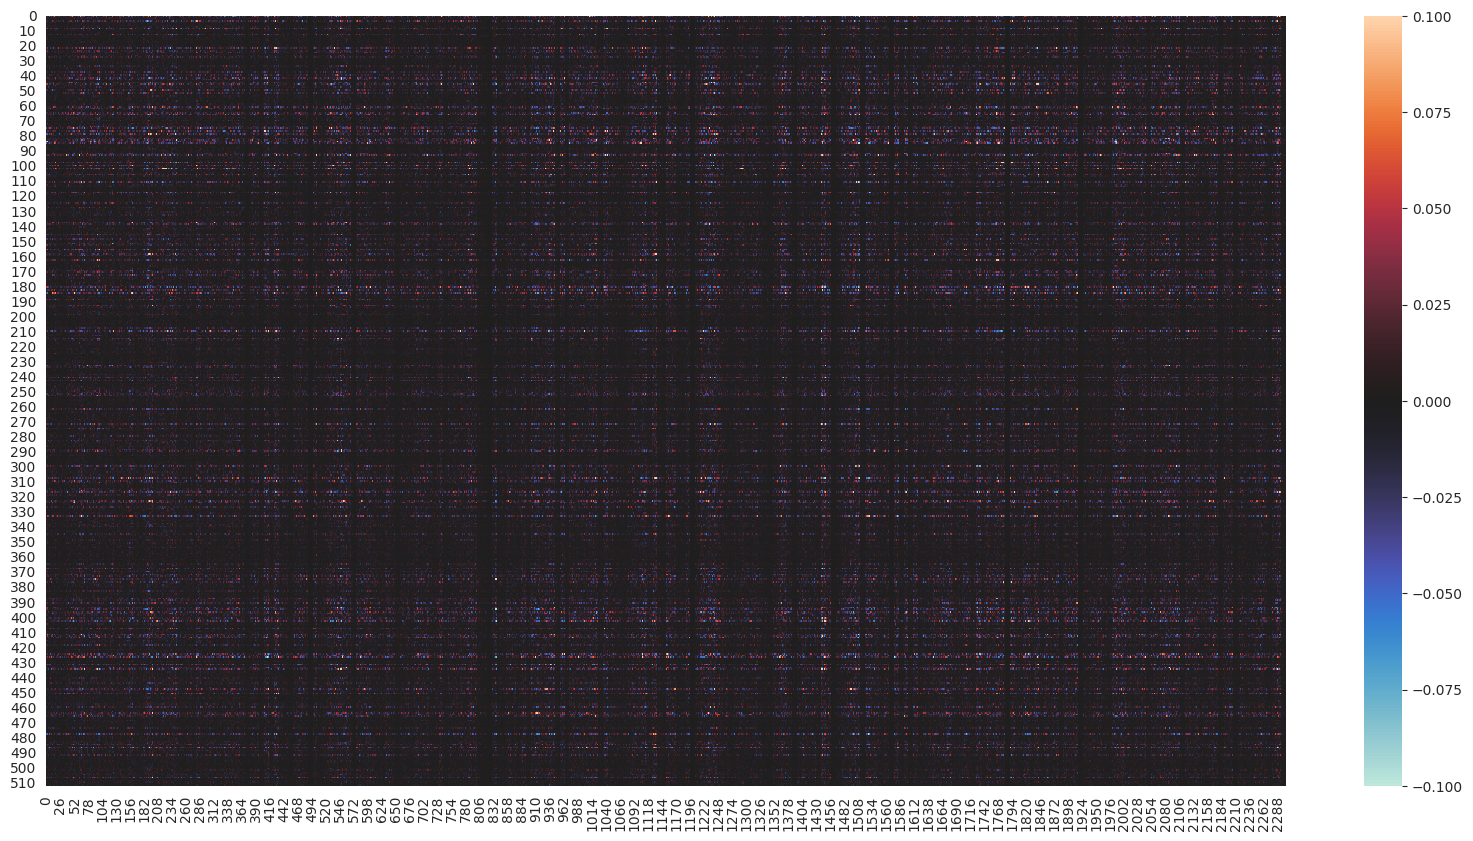

In [39]:
plt.figure(figsize=(20,10))
conv = exp.model.layer4[0].conv1
show_heatmap(conv)
np.save('svd_conv4', conv.weight.data.cpu().numpy())

In [36]:
baseline = resnet18(num_classes=21)
baseline.load_state_dict(torch.load('trained_model.sd.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [47]:
save_numpy(baseline, 'baseline')

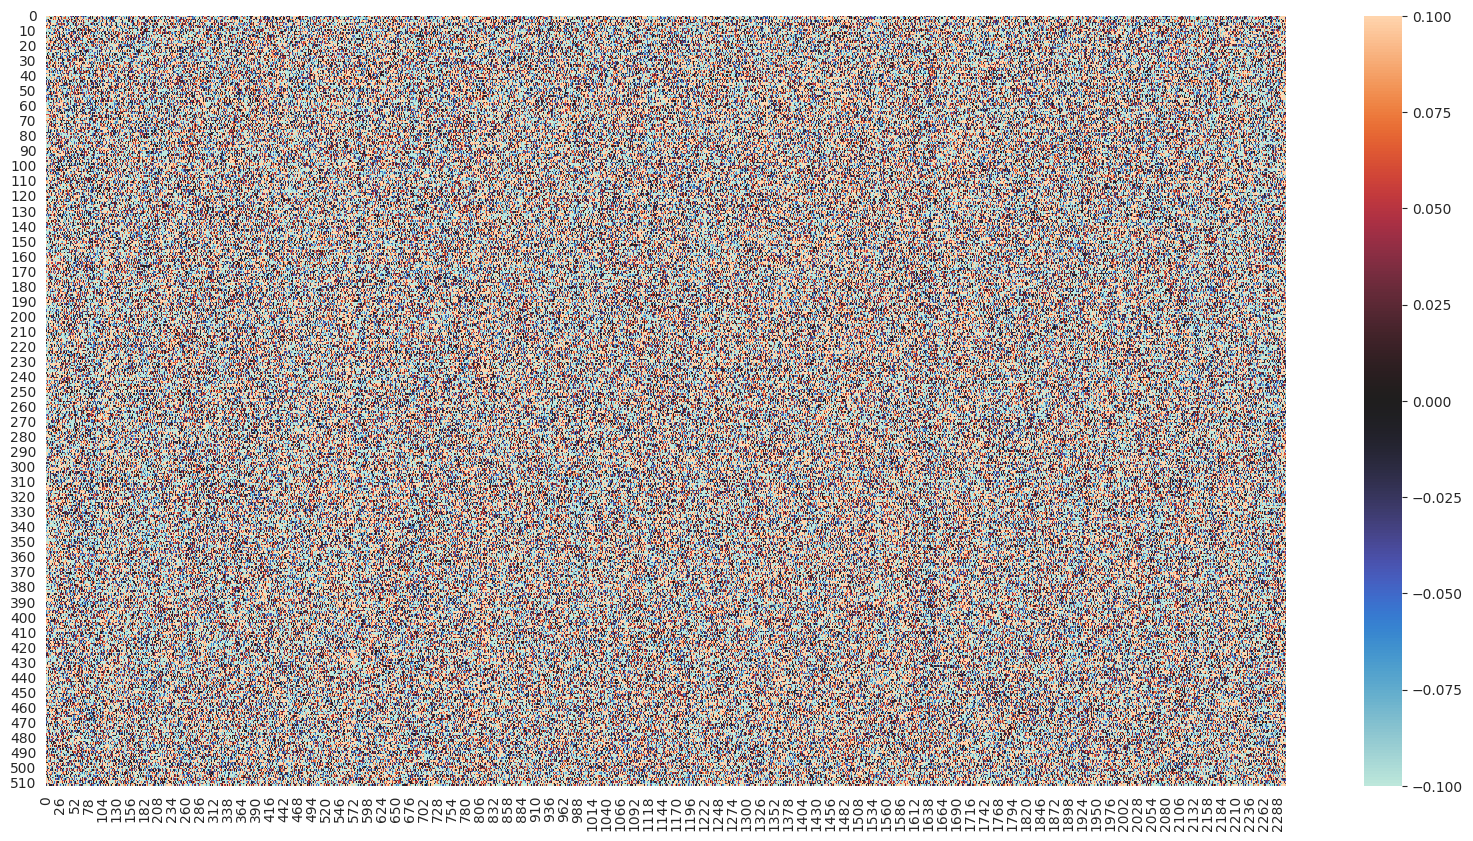

In [37]:
plt.figure(figsize=(20,10))
conv = baseline.layer4[0].conv1
show_heatmap(conv)
np.save('baseline_conv4', conv.weight.data.cpu().numpy())

2023-02-13 19:28:39,005 - SFPOptimization - Model loaded.


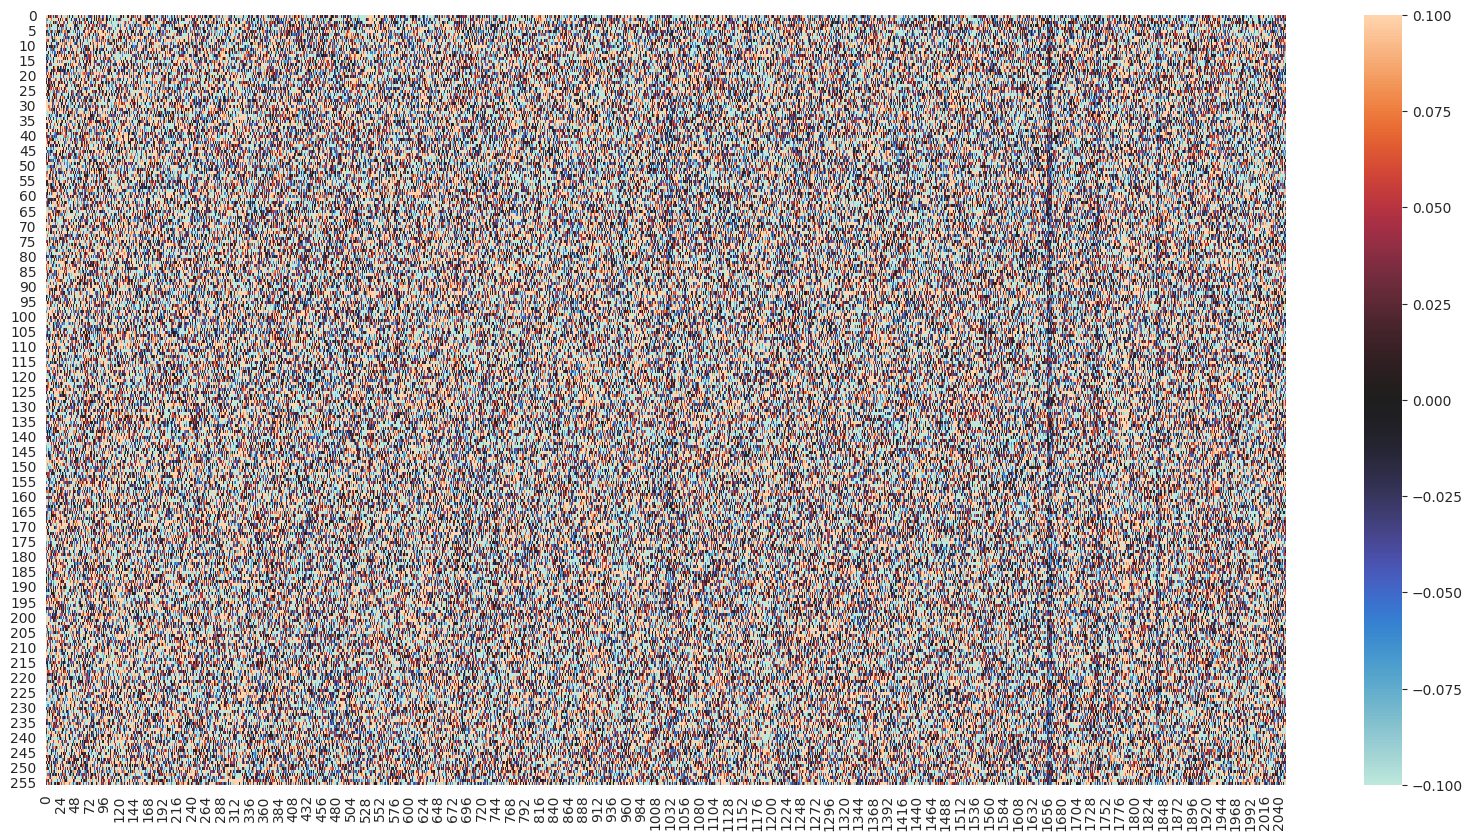

In [38]:
plt.figure(figsize=(20,10))
sfp = SFPOptimization(pruning_ratio=0.5)
exp_sfp = ClassificationExperimenter(model=resnet18(num_classes=21))
sfp.load_model(exp=exp_sfp, state_dict_path='fine-tuning.sd.pt')
conv = exp_sfp.model.layer4[0].conv1
show_heatmap(conv)
np.save('sfp_conv4', conv.weight.data.cpu().numpy())